# Imbalanced Learning
- Make a synthetic dataset using sklearn
- Train a decision tree classifier with stratified k-fold cross-validation.
- Performances assessment with AUC ROC, average precision and balanced accuracy

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})


In [7]:
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=1, weights=[0.95, 0.05], class_sep=0.5, random_state=0)

dataset_df = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'Y': y,
})


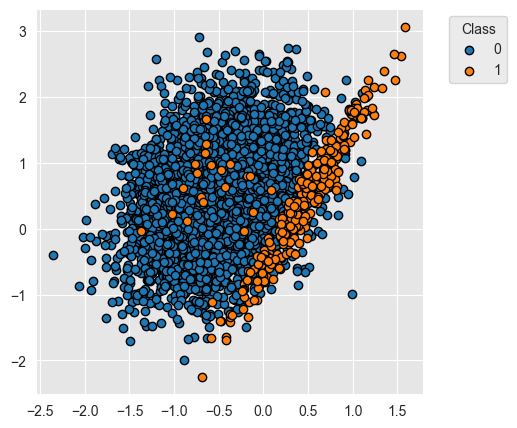

In [9]:

fig_distribution, ax = plt.subplots(1, 1, figsize=(5, 5))

groups = dataset_df.groupby('Y')
for name, group in groups:
    ax.scatter(group.X1, group.X2, edgecolors='k',
               label=name, alpha=1, marker='o')

ax.legend(loc='upper left',
          bbox_to_anchor=(1.05, 1),
          title='Class')


## Decision Tree with class weights set to 1

In [11]:
tree = DecisionTreeClassifier(max_depth=5, class_weight={
                              0: 1, 1: 1}, random_state=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)


In [14]:
cv_results_ = cross_validate(tree, X, y, cv=cv,
                             scoring=['roc_auc', 'average_precision',
                                      'balanced_accuracy'],
                             return_estimator=True)

results = round(pd.DataFrame(cv_results_), 3)
results


,fit_time,score_time,estimator,test_roc_auc,test_average_precision,test_balanced_accuracy
0,0.005,0.002,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.933,0.616,0.842
1,0.005,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.871,0.493,0.739
2,0.006,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.897,0.493,0.799
3,0.084,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.928,0.591,0.812
4,0.019,0.001,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.901,0.447,0.738


In [16]:
# Taking mean and std of performances across all folds
results_mean = list(results.mean().values)
results_std = list(results.std().values)

final_results = pd.DataFrame([[str(round(results_mean[i], 3)) + '+/-' + str(round(results_std[i], 3)) for i in range(len(results))]],
                             columns=['Fit time (s)', 'Score time (s)', 'AUC ROC', 'Average Precision', 'Balanced Accuracy'])
final_results


/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_5916/4064935214.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_mean = list(results.mean().values)
/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_5916/4064935214.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_std = list(results.std().values)


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced Accuracy
0,0.024+/-0.034,0.001+/-0.0,0.906+/-0.025,0.528+/-0.072,0.786+/-0.046


- AUC ROC needs to be > 0.5, and average precision needs to be > 0.05
- Performance is rather good, since AUC ROC is 0.906 and average precision is 0.528
- But balanced accuracy is not so high, suggesting the decision boundary misclassifies many of the samples from the minority class.

## Plotting the decision boundaries by one of the decision trees

#### Defining some functions for k-fold CV and plotting

In [18]:
def plot_decision_boundary_classifier(ax, classifier, train_df,
                                      input_features=['X1', 'X2'], output_feature='Y',
                                      title="", fs=14, plot_training_data=True):
    plot_colors = ['tab:blue', 'tab:orange']

    x1_min, x1_max = train_df[input_features[0]].min(
    ) - 1, train_df[input_features[0]].max() + 1
    x2_min, x2_max = train_df[input_features[1]].min(
    ) - 1, train_df[input_features[1]].max() + 1

    plot_step = 0.1
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, plot_step),
                         np.arange(x2_min, x2_max, plot_step))

    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu_r, alpha=0.3)

    if plot_training_data:
        # Plot the training points
        groups = train_df.groupby(output_feature)
        for name, group in groups:
            ax.scatter(group[input_features[0]],
                       group[input_features[1]], edgecolors='black', label=name)

    ax.set_title(title, fontsize=fs)
    ax.set_xlabel(input_features[0], fontsize=fs)
    ax.set_ylabel(input_features[1], fontsize=fs)


In [19]:
# Retrieve the decision tree from the first fold of CV
classifier_0 = cv_results_['estimator'][0]

# Retrive the indices used for training and testing of the first fold of CV
(train_index, test_index) = next(cv.split(X, y))

# Recreate the train and test DataFrames from these indices
train_df = pd.DataFrame({
    'X1': X[train_index, 0],
    'X2': X[train_index, 1],
    'Y': y[train_index],
})
test_df = pd.DataFrame({
    'X1': X[test_index, 0],
    'X2': X[test_index, 1],
    'Y': y[test_index],
})
input_features = ['X1', 'X2']
output_feature = 'Y'


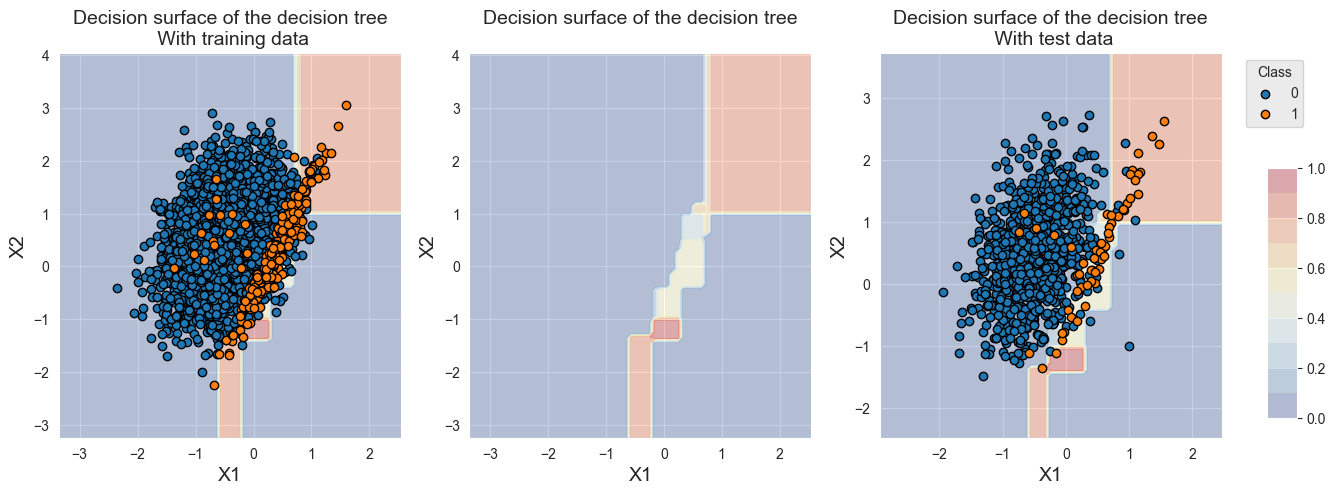

In [22]:
# Plot the decision boundaries using the above data and functions

fig_decision_boundary, ax = plt.subplots(1, 3, figsize=(5*3, 5))

plot_decision_boundary_classifier(ax[0], classifier_0,
                                  train_df,
                                  title='Decision surface of the decision tree\n With training data',
                                  plot_training_data=True)
plot_decision_boundary_classifier(ax[1], classifier_0,
                                  train_df,
                                  title='Decision surface of the decision tree\n',
                                  plot_training_data=False)
plot_decision_boundary_classifier(ax[2], classifier_0,
                                  test_df,
                                  title='Decision surface of the decision tree\n With test data',
                                  plot_training_data=True)

ax[-1].legend(loc='upper left',
              bbox_to_anchor=(1.05, 1),
              title='Class')

sm = plt.cm.ScalarMappable(
    cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=0, vmax=1))
cax = fig_decision_boundary.add_axes([0.93, 0.15, 0.02, 0.5])
fig_decision_boundary.colorbar(
    sm, cax=cax, alpha=0.3, boundaries=np.linspace(0, 1, 11))


- The tree correctly identifies the minority class
- The tree struggles near the overlap region and classifies most samples into the majority class.
- We will write two more functions for computing CV results and for plotting decision boundaries

In [26]:
def kfold_cv_with_classifier(classifier,
                             X,
                             y,
                             n_splits=5,
                             strategy_name='Baseline Classifier'):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    cv_results_ = cross_validate(classifier, X, y, cv=cv,
                                 scoring=['roc_auc', 'average_precision',
                                          'balanced_accuracy'],
                                 return_estimator=True)

    results = round(pd.DataFrame(cv_results_), 3)
    results_mean = list(results.mean().values)
    results_std = list(results.std().values)
    results_df = pd.DataFrame([[str(round(results_mean[i], 3)) + '+/-' + str(round(results_std[1], 3)) for i in range(len(results))]],
                              columns=['Fit time (s)', 'Score time (s)', 'AUC ROC', 'Average Precision', 'Balanced Accuracy'])
    results_df.rename(index={0: strategy_name}, inplace=True)

    classifier_0 = cv_results_['estimator'][0]

    (train_index, test_index) = next(cv.split(X, y))
    train_df = pd.DataFrame({
        'X1': X[train_index, 0],
        'X2': X[train_index, 1],
        'Y': y[train_index],
    })
    test_df = pd.DataFrame({
        'X1': X[test_index, 0],
        'X2': X[test_index, 1],
        'Y': y[test_index],
    })

    return (results_df, classifier_0, train_df, test_df)


In [27]:
def plot_decision_boundary(classifier_0,
                           train_df,
                           test_df):
    fig_decision_boundary, ax = plt.subplots(1, 3, figsize=(5*3, 5))
    plot_decision_boundary_classifier(ax[0], classifier_0,
                                  train_df,
                                  title='Decision surface of the decision tree\n With training data',
                                  plot_training_data=True)
    plot_decision_boundary_classifier(ax[1], classifier_0,
                                    train_df,
                                    title='Decision surface of the decision tree\n',
                                    plot_training_data=False)
    plot_decision_boundary_classifier(ax[2], classifier_0,
                                    test_df,
                                    title='Decision surface of the decision tree\n With test data',
                                    plot_training_data=True)

    ax[-1].legend(loc='upper left',
                bbox_to_anchor=(1.05, 1),
                title='Class')

    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=0, vmax=1))
    cax = fig_decision_boundary.add_axes([0.93, 0.15, 0.02, 0.5])
    fig_decision_boundary.colorbar(sm, cax=cax, alpha=0.3, boundaries=np.linspace(0, 1, 11))

    return fig_decision_boundary

    


/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_5916/3295125161.py:14: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_mean = list(results.mean().values)
/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_5916/3295125161.py:15: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_std = list(results.std().values)


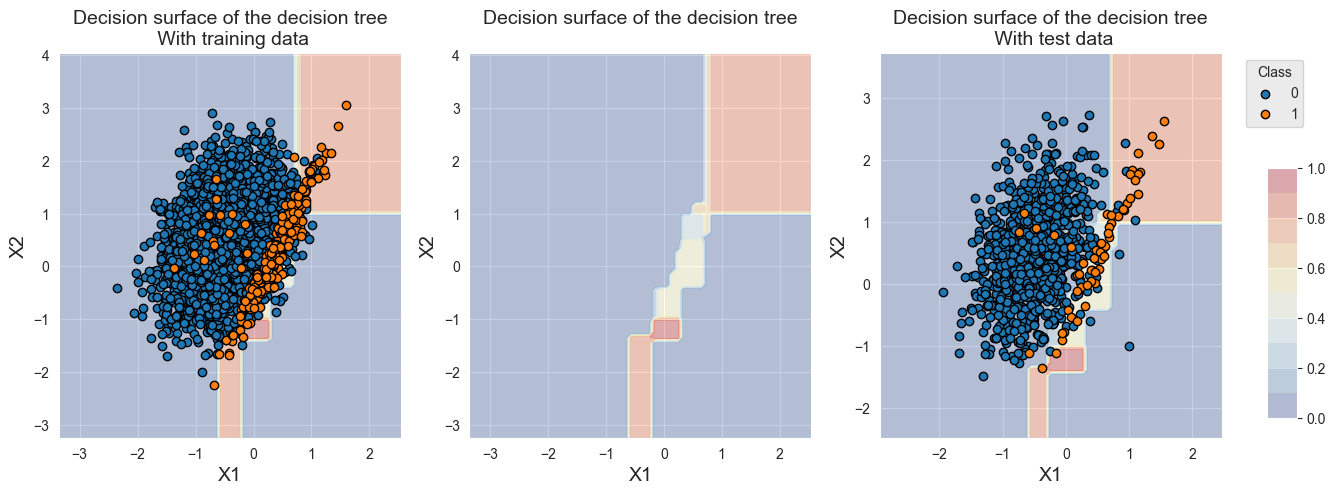

In [28]:
# Recomputing the performances and decision boundaries with these two functions.

classifier = DecisionTreeClassifier(max_depth=5, class_weight={0:1, 1:1}, random_state=0)

(results_df_dt_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, X, y, n_splits=5, strategy_name='Decision Tree Baseline')

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

### Setting class weights so that False Positives have a weight equal to the imbalance ratio

In [29]:
IR = 0.05/0.95

class_weight={0:IR,1:1}

classifier = DecisionTreeClassifier(max_depth=5, class_weight=class_weight, random_state=0)

(results_df_dt_cost_sensitive, classifier_0, train_df, test_df) = \
    kfold_cv_with_classifier(classifier, X, y, n_splits=5, strategy_name='Decision tree - Cost-sensitive')



/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_5916/3295125161.py:14: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_mean = list(results.mean().values)
/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_5916/3295125161.py:15: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_std = list(results.std().values)


In [30]:
pd.concat([results_df_dt_baseline, results_df_dt_cost_sensitive])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced Accuracy
Decision Tree Baseline,0.004+/-0.0,0.001+/-0.0,0.906+/-0.0,0.528+/-0.0,0.786+/-0.0
Decision tree - Cost-sensitive,0.003+/-0.003,0.002+/-0.003,0.887+/-0.003,0.471+/-0.003,0.898+/-0.003


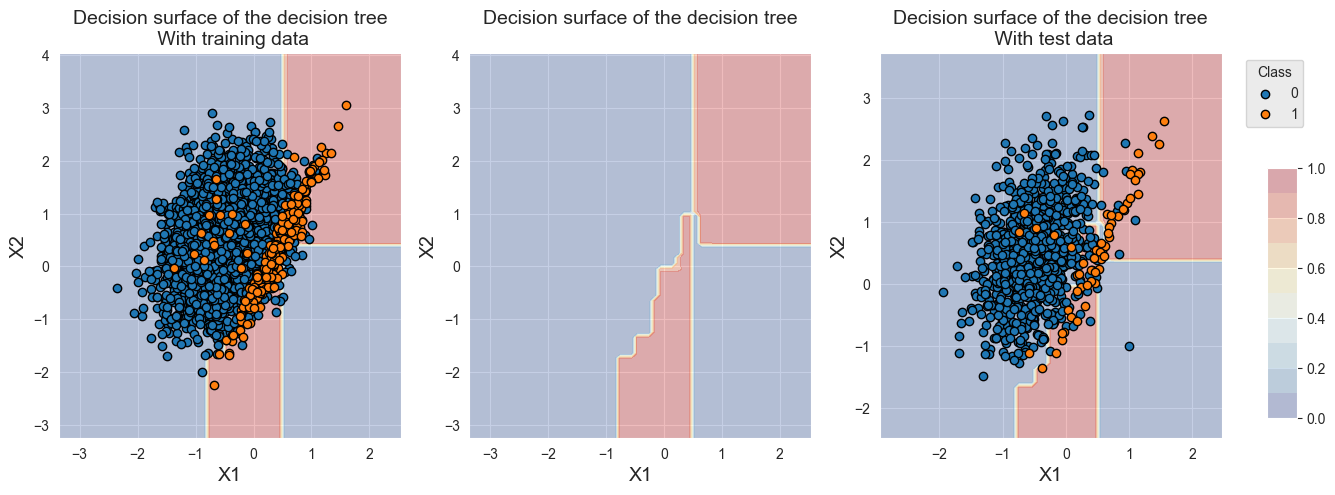

In [31]:
fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

- This is amazing! The decision boundary has shifted towards samples from the minority class.
- The balanced accuracy has increased from 0.786 to 0.898
- But the AUC ROC and the Average Precision have decreased.


## Applying Logistic Regression
- Apply the same methodology with a logistic regression classifier.
- First, a classifier with equal weights for both classes.
- Second, a classifier with IR weight for the majority class.

/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_5916/3295125161.py:14: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_mean = list(results.mean().values)
/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_5916/3295125161.py:15: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_std = list(results.std().values)


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced Accuracy
Logistic Regression Baseline,0.003+/-0.0,0.001+/-0.0,0.937+/-0.0,0.535+/-0.0,0.641+/-0.0


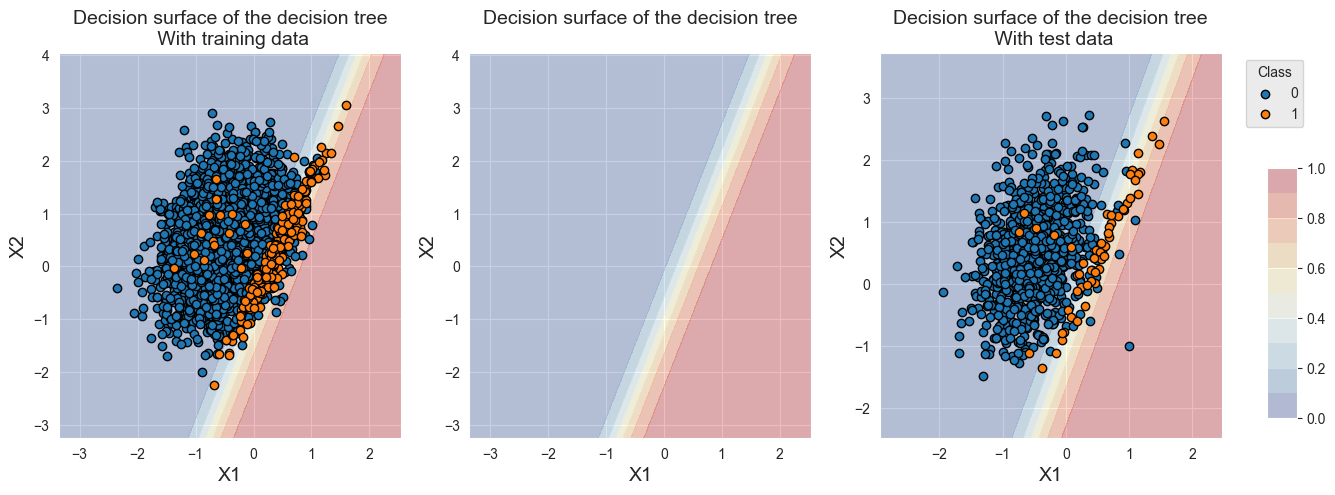

In [34]:
classifier = LogisticRegression(C=1, class_weight={0:1,1:1}, random_state=0)

(results_df_lr_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, X, y, n_splits=5, strategy_name='Logistic Regression Baseline')

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

results_df_lr_baseline


- Performance for AUC ROC and Average Precision are higher than Decision Tree
- Balanced Accuracy is lower.
- Due to class imbalance, the decision boundary slightly favors the majority class.
- Changing class weights now

/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_5916/3295125161.py:14: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_mean = list(results.mean().values)
/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_5916/3295125161.py:15: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_std = list(results.std().values)


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced Accuracy
Logistic Regression Baseline,0.003+/-0.0,0.001+/-0.0,0.937+/-0.0,0.535+/-0.0,0.641+/-0.0
Logistic Regression - Cost-Sensitive,0.002+/-0.0,0.001+/-0.0,0.937+/-0.0,0.536+/-0.0,0.899+/-0.0


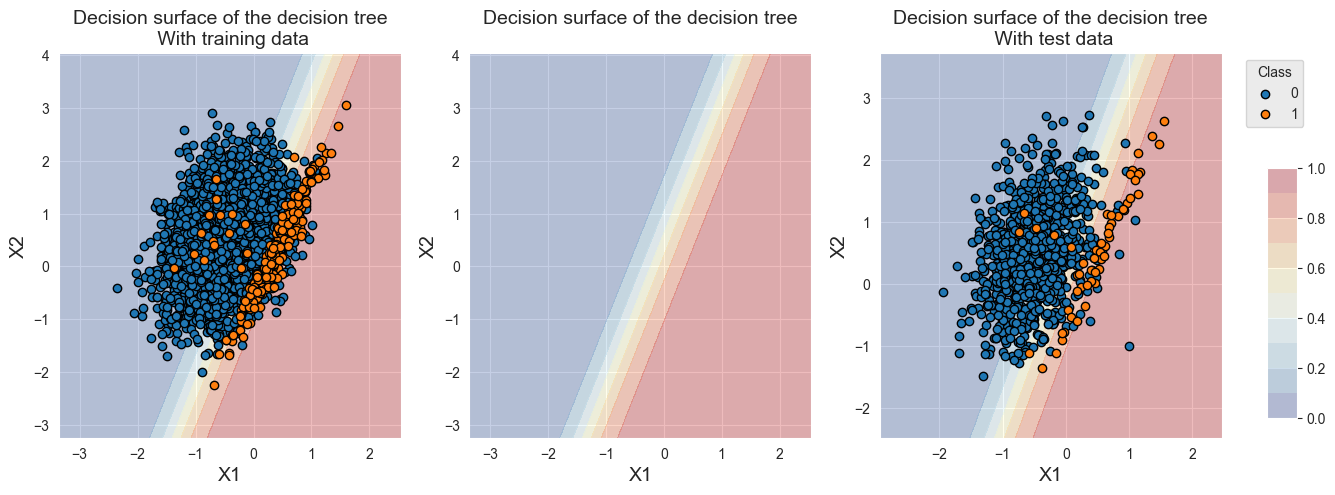

In [35]:
classifier = LogisticRegression(C=1, class_weight={0:IR,1:1}, random_state=0)

(results_df_lr_cost_sensitive, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, X, y, n_splits=5, strategy_name='Logistic Regression - Cost-Sensitive')

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

pd.concat([results_df_lr_baseline, results_df_lr_cost_sensitive])

- We observe that both AUC ROC and Average Precision have stayed the same from baseline AND there is a significant improvement in the Balanced Accuracy!!
- Concatenating all results into one place.

In [36]:
results_df = pd.concat([
    results_df_dt_baseline,
    results_df_dt_cost_sensitive,
    results_df_lr_baseline,
    results_df_lr_cost_sensitive
])
results_df

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced Accuracy
Logistic Regression Baseline,0.003+/-0.0,0.001+/-0.0,0.937+/-0.0,0.535+/-0.0,0.641+/-0.0
Decision tree - Cost-sensitive,0.003+/-0.003,0.002+/-0.003,0.887+/-0.003,0.471+/-0.003,0.898+/-0.003
Logistic Regression Baseline,0.003+/-0.0,0.001+/-0.0,0.937+/-0.0,0.535+/-0.0,0.641+/-0.0
Logistic Regression - Cost-Sensitive,0.002+/-0.0,0.001+/-0.0,0.937+/-0.0,0.536+/-0.0,0.899+/-0.0
